In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta


In [6]:

# Configurable variables
SEQUENCE_LENGTH = 144*5  # Number of consecutive datapoints (144 is 1 day with 10-min intervals, 5 days total)
SEQUENCE_STEP = 144 # always 1 day step

TRAIN_EVENT_IDS = [79, 65]  # Event IDs for training
TEST_EVENT_IDS = [30, 46]  # Event IDs for testing
TIME_STEP = timedelta(minutes=10)  # Expected time difference between consecutive rows

# File paths
ASSET_NUMBER = 16
DATA_PATH = f'./by_asset/C/assets/{ASSET_NUMBER}.csv'
EVENTS_PATH = f'./by_asset/C/assets/{ASSET_NUMBER}_events.csv'
FEATURE_DESCRIPTION_PATH = './CARE_To_Compare/Wind Farm C/feature_description.csv'


def load_data():
    """Load the sensor data, event data, and feature descriptions."""
    data = pd.read_csv(DATA_PATH, sep=';')
    events = pd.read_csv(EVENTS_PATH, sep=';')
    feature_description = pd.read_csv(FEATURE_DESCRIPTION_PATH, sep=';')
    return data, events, feature_description


def preprocess_data(data, events):
    """Preprocess the data by converting timestamps and assigning event labels."""
    # Convert time columns to datetime
    data['time_stamp'] = pd.to_datetime(data['time_stamp'])
    events['event_start'] = pd.to_datetime(events['event_start'])
    events['event_end'] = pd.to_datetime(events['event_end'])

    # Assign event labels to the data
    data['event'] = 'other'
    for _, event in events.iterrows():
        mask = (data['time_stamp'] >= event['event_start']) & (data['time_stamp'] <= event['event_end'])
        data.loc[mask, 'event'] = event['event_label']

    # Map event labels to binary classes
    data['event_class'] = data['event'].apply(lambda x: 1 if x == 'anomaly' else 0)
    return data


def create_sensor_mapping(feature_description):
    """Create a mapping of sensor names to their descriptions and units."""
    required_columns = {'sensor_name', 'description', 'unit'}
    if not required_columns.issubset(feature_description.columns):
        raise ValueError(f"The feature description file must contain the columns: {required_columns}")

    shorthand_to_longhand = {
        '_avg': 'average',
        '_max': 'maximum',
        '_min': 'minimum',
        '_std': 'std_dev'
    }

    sensor_mapping = {}
    for _, row in feature_description.iterrows():
        base_sensor = row['sensor_name']
        description = row['description']
        unit = row['unit']
        for shorthand, longhand in shorthand_to_longhand.items():
            full_sensor_name = f"{base_sensor}{shorthand}"
            full_description = f"{base_sensor}: {description} [{unit}] ({longhand})"
            sensor_mapping[full_sensor_name] = full_description
    return sensor_mapping


def create_sequences(data, sequence_length, time_step):
    """Create sequences of consecutive datapoints."""
    sequences = []
    labels = []
    timestamps = []

    # Identify gaps in time
    data['time_diff'] = data['time_stamp'].diff().fillna(pd.Timedelta(seconds=0))
    data['is_continuous'] = data['time_diff'] <= time_step

    # Reset the index whenever there is a gap
    data['group'] = (~data['is_continuous']).cumsum()

    # Select only numeric columns for the model
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ['event_class', 'time_diff', 'is_continuous', 'group']]

# Define a step size to reduce overlap and memory (e.g., 1/4 of SEQUENCE_LENGTH)

# In create_sequences function:
    # Process each group separately
    for _, group_data in data.groupby('group'):
        group_data = group_data.reset_index(drop=True)
        # Change range(..., 1) to range(..., SEQUENCE_STEP)
        for i in range(0, len(group_data) - sequence_length + 1, SEQUENCE_STEP):
            sequence = group_data.iloc[i:i + sequence_length]
            # ... rest of logic remains the same
            sequences.append(sequence[numeric_columns].values.flatten())
            labels.append(sequence['event_class'].mean())
            timestamps.append(sequence['time_stamp'].iloc[sequence_length - 1]) # Use end time for clarity
            timestamps.append(sequence['time_stamp'].iloc[0])  # Keep track of the start time of the sequence

    return np.array(sequences), np.array(labels), timestamps


def prepare_data_with_other(data, events, event_ids, sequence_length, time_step, pre_event_window):
    """Prepare data for training/testing, including 'other' data leading up to the event."""
    filtered_data = pd.DataFrame()
    for event_id in event_ids:
        event = events[events['event_id'] == event_id]
        for _, row in event.iterrows():
            # Start time is BEFORE the event (the PRE_EVENT_WINDOW)
            start_time = row['event_start'] - pre_event_window
            end_time = row['event_end']
            event_data = data[(data['time_stamp'] >= start_time) & (data['time_stamp'] <= end_time)]
            filtered_data = pd.concat([filtered_data, event_data])

    # Sort by timestamp to ensure proper sequencing and drop duplicates
    filtered_data = filtered_data.sort_values(by='time_stamp').drop_duplicates(subset=['time_stamp'], keep='first')
    return create_sequences(filtered_data, sequence_length, time_step), filtered_data

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    """Train an XGBoost REGRESSOR model and evaluate its performance."""
    print("--- Model Training (XGBoost Regressor) ---")
    
    # 1. Instantiate Regressor
    model = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=100, 
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # 2. Reshape 3D sequence data (samples, seq_len, features) to 2D (samples, seq_len * features)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # 3. Fit the model
    model.fit(X_train_flat, y_train)
    print("Model training complete.")

    # 4. Evaluate the model
    y_pred = model.predict(X_test_flat)
    
    # Calculate Regression Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Evaluation (Regression Metrics) ---")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Test R-squared (R2): {r2:.4f}")

    # Return the trained model
    return model


def plot_sensor(data, sensor_mapping):
    """Create an interactive plot for sensor data."""
    def plot(sensor_id):
        if sensor_id not in data.columns:
            raise ValueError(f"Sensor '{sensor_id}' not found in the data.")

        plt.figure(figsize=(12, 6))

        # Filter data based on event type
        anomaly = data[data['event'] == 'anomaly']
        normal = data[data['event'] == 'normal']
        other = data[data['event'] == 'other']

        # Plot data with different colors, ensuring red and green are on top
        plt.plot(other['time_stamp'], other[sensor_id], 'b.', label='Other', alpha=0.5)
        plt.plot(normal['time_stamp'], normal[sensor_id], 'g.', label='Normal', alpha=0.8)
        plt.plot(anomaly['time_stamp'], anomaly[sensor_id], 'r.', label='Anomaly', alpha=0.8)

        plt.title(f'Plot of {sensor_mapping[sensor_id]}')
        plt.xlabel('Time Stamp')
        plt.ylabel(sensor_mapping[sensor_id])
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()
        plt.show()

    # Create a dropdown for sensor selection
    sensor_columns = [col for col in data.columns if col.startswith('sensor_') or col.startswith('power_') or col.startswith('wind_speed_')]
    sensor_options = {sensor_mapping[sensor]: sensor for sensor in sensor_columns if sensor in sensor_mapping}

    if not sensor_options:
        raise ValueError("No matching sensors found between the data and the feature description file.")

    interact(plot, sensor_id=Dropdown(options=sensor_options, description='Select Sensor:'))


data, events, feature_description = load_data()
data = preprocess_data(data, events)





/var/folders/75/ql8v_2rx6v31k_cvbx9k4t500000gn/T/ipykernel_66030/1384654871.py:18: DtypeWarning: Columns (963) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH, sep=';')


In [7]:
sensor_mapping = create_sensor_mapping(feature_description)

# Plot sensor data
plot_sensor(data, sensor_mapping)


interactive(children=(Dropdown(description='Select Sensor:', options={'sensor_0: ABB-LS Input K1, IL1 [A] (ave…

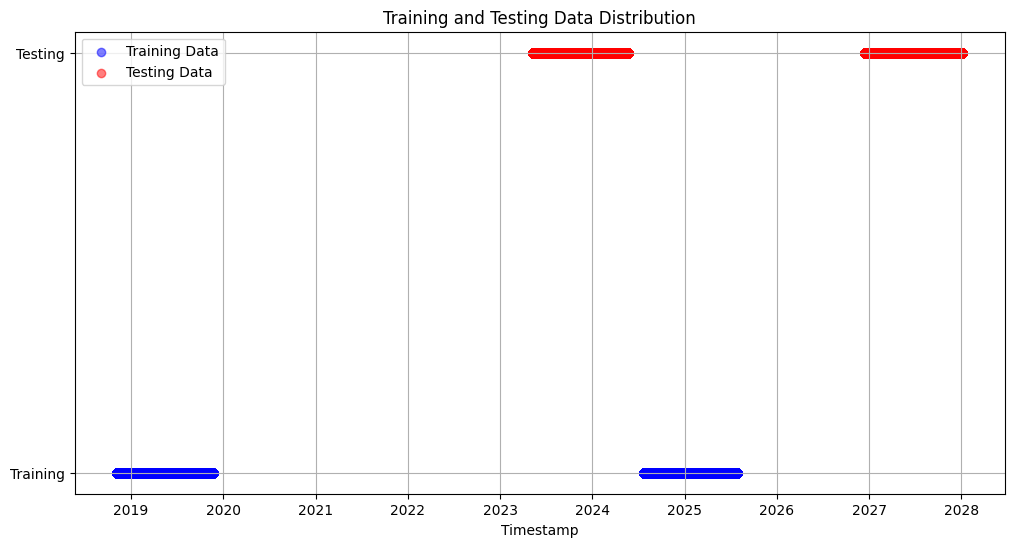

--- Model Training (XGBoost Regressor) ---
Model training complete.

--- Model Evaluation (Regression Metrics) ---
Test Root Mean Squared Error (RMSE): 0.1570
Test Mean Absolute Error (MAE): 0.0260
Test R-squared (R2): 0.0008


/Users/osma/ARotor/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


interactive(children=(Dropdown(description='Select Event ID:', options=(30, 46), value=30), Output()), _dom_cl…

In [11]:
# Prepare training and testing data, including "other" data leading up to the events
PRE_EVENT_WINDOW = timedelta(hours=int(365*24))  # Time window before the event to include "other" data, we want to use one year


def plot_training_testing_data(train_data, test_data):
    """Visualize which data is used for training and testing."""
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.scatter(train_data['time_stamp'], [0] * len(train_data), color='blue', label='Training Data', alpha=0.5)

    # Plot testing data
    plt.scatter(test_data['time_stamp'], [1] * len(test_data), color='red', label='Testing Data', alpha=0.5)

    plt.title("Training and Testing Data Distribution")
    plt.xlabel("Timestamp")
    plt.yticks([0, 1], ['Training', 'Testing'])
    plt.legend()
    plt.grid()
    plt.show() 


# Prepare training and testing data
(train_sequences, train_labels, train_timestamps), train_data = prepare_data_with_other(
    data, events, TRAIN_EVENT_IDS, SEQUENCE_LENGTH, TIME_STEP, PRE_EVENT_WINDOW
)
(test_sequences, test_labels, test_timestamps), test_data = prepare_data_with_other(
    data, events, TEST_EVENT_IDS, SEQUENCE_LENGTH, TIME_STEP, PRE_EVENT_WINDOW
)

# Plot the training and testing data distribution
plot_training_testing_data(train_data, test_data)

# Train and evaluate the model, and assign the returned model
model = train_and_evaluate_model(train_sequences, train_labels, test_sequences, test_labels)

def compare_labels(event_id):
    # Filter the test data for the selected event
    event = events[events['event_id'] == event_id]
    if event.empty:
        print(f"No data found for event ID {event_id}")
        return

    # Extract the data leading up to the event (using the same logic as prepare_data_with_other)
    event_data = pd.DataFrame()
    for _, row in event.iterrows():
        start_time = row['event_start'] - PRE_EVENT_WINDOW
        end_time = row['event_end']
        event_data = pd.concat([event_data, data[(data['time_stamp'] >= start_time) & (data['time_stamp'] <= end_time)]])

    # Ensure the data is sorted and de-duplicated
    event_data = event_data.sort_values(by='time_stamp').drop_duplicates(subset=['time_stamp'], keep='first').reset_index(drop=True)

    # Create sequences for the event data
    X_event, y_event, event_timestamps = create_sequences(event_data, SEQUENCE_LENGTH, TIME_STEP)
    
    if len(X_event) == 0:
        print(f"Not enough continuous data to form sequences for event ID {event_id}.")
        return

    # >>> NEW FIX HERE: Ensure the timestamp array matches the sequence length <<<
    if len(event_timestamps) != len(y_event):
        # Trim the timestamps to match the length of the labels/sequences
        event_timestamps = event_timestamps[:len(y_event)] 
        
    # FIX: Reshape 3D sequence data to 2D for prediction
    X_event_flat = X_event.reshape(X_event.shape[0], -1)

    # Predict labels for the event data
    y_pred_event = model.predict(X_event_flat)

    # Plot the true and predicted healthiness scores
    plt.figure(figsize=(12, 6))
    # Matplotlib will now plot x (event_timestamps) and y (y_event) with equal dimensions (49)
    plt.plot(event_timestamps, y_event, label='True Healthiness Score (Anomaly Proportion)', color='blue', linestyle='-')
    plt.plot(event_timestamps, y_pred_event, label='Predicted Healthiness Score', color='red', linestyle='--')
    plt.title(f"True vs Predicted Healthiness Score for Event ID {event_id}")
    plt.xlabel("Sequence End Timestamp")
    plt.ylabel("Healthiness Score (0.0 to 1.0)")
    plt.xticks(rotation=45)
    plt.ylim(-0.05, 1.05) # Constrain plot range for clarity
    plt.legend()
    plt.grid()
    plt.show()
# Create an interactive dropdown to select an event ID for comparison
def interactive_comparison():
    event_ids = TEST_EVENT_IDS  # Use test event IDs for comparison
    interact(compare_labels, event_id=Dropdown(options=event_ids, description='Select Event ID:'))

# Call the interactive comparison function
interactive_comparison()